In [1]:
# Importing the libraries
import gc
import glob
import json
import math
import os
import pickle
import subprocess
import time
import wandb

import matplotlib
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from spacepy import pycdf
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary
from torchvision.models.feature_extraction import (create_feature_extractor,
                                                   get_graph_node_names)
from datetime import datetime
from functools import partial
from multiprocessing import Manager, Pool


import scipy.io
# import shapely
from dateutil import parser
# from geopack import geopack, t89
from matplotlib.cm import ScalarMappable
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib.patches import Circle, Wedge
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from tqdm import tqdm
import data_prep as dp


/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
import data_prep as dp
import swmag_model as modeling

data_dir = '../../../../data/'
TARGET='dbht_max'
VERSION='extended_v0-1_dbht'

with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

for CLUSTER in cluster_dict.keys():
	for REGION in cluster_dict[CLUSTER]['regions'].keys():

		CONFIG = {'time_history':60,
					'random_seed':42,
					'filters':128,
					'learning_rate':1e-7,
					'early_stop_patience':25,
					'batch_size':128,
					'epochs':500,
					'loss':'BCE',
					'using_weights_for_imbalance':True,
					'oversampling':False,
					'target':TARGET,
					'target_dim':2,
					'region':REGION,
					'final_activation':'softmax',
					'other_notes': 'lead: 18H+60, recovery 18H+60'
					}
		DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
		print(f'Device: {DEVICE}')

		data_prep = dp.PreparingData(target_param=TARGET, region=REGION, cluster=CLUSTER, oversampling=False, 
								omni=False, config=CONFIG, features=['dbht', 'MAGNITUDE', 'theta', 'N', 'E', 'sin_theta', 'cos_theta'], 
								mean=True, std=True, maximum=True, median=True, window=60, forecast=30, classification=True, version=VERSION,
								start_time='2018-01-01', end_time='2024-12-31 23:59:00', ml_challenge=True)

		test_storm_dict = data_prep.preping_specific_test_storms(storm_list=['2023-01-04 09:04:00', '2023-05-06 05:11:00', '2024-05-11 02:14:00'], solar_wind_data='dscovr')

		test_size = list(test_storm_dict['storms'].shape)

		test = DataLoader(list(zip(torch.tensor(test_storm_dict['storms']).unsqueeze(1), torch.tensor(test_storm_dict['targets']))), batch_size=CONFIG['batch_size'], shuffle=False)

		torch.manual_seed(CONFIG['random_seed'])
		torch.cuda.manual_seed(CONFIG['random_seed'])
		model = modeling.SWMAG()

		# printing model summary
		model.to(DEVICE)
		print(summary(model, (1, test_size[1], test_size[2])))

		checkpoint = torch.load(f'{data_dir}mike_working_dir/including_ion_temp_maps/models/{TARGET}/region_{REGION}_{VERSION}.pt')
		model.load_state_dict(checkpoint['model'])

		results_df = modeling.evaluation(model, test, test_storm_dict['dates'])
		results_df.reset_index(drop=True, inplace=True)

		results_df.to_feather(f'{data_dir}mike_working_dir/including_ion_temp_maps/outputs/{TARGET}/ml_challenge_region_{REGION}_{VERSION}.feather')

Device: cuda
Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-0
Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
THIS IS THE SET THRESHOLD: 9.124143600463867
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.


/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2d-3           [-1, 128, 30, 8]               0
            Conv2d-4           [-1, 256, 30, 8]         131,328
              ReLU-5           [-1, 256, 30, 8]               0
            Linear-6                  [-1, 256]      15,728,896
              ReLU-7                  [-1, 256]               0
           Dropout-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                    [-1, 2]             258
          Softmax-13                    [-1, 2]               0
Total params: 15,894,018
Trainable para

 99%|█████████▉| 99/100 [00:11<00:00,  8.43it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-1
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
THIS IS THE SET THRESHOLD: 13.711674690246582
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]  

 98%|█████████▊| 98/100 [00:07<00:00, 12.94it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:07<00:00, 12.91it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-2
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
THIS IS THE SET THRESHOLD: 30.79951286315918
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]   

 99%|█████████▉| 99/100 [00:12<00:00,  8.16it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-0
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
THIS IS THE SET THRESHOLD: 65.84011840820312
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1,

 99%|█████████▉| 99/100 [00:11<00:00,  8.24it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-1
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
THIS IS THE SET THRESHOLD: 63.4924430847168
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 

 99%|█████████▉| 99/100 [00:11<00:00,  8.27it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-2
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
THIS IS THE SET THRESHOLD: 61.03449630737305
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1,

 99%|█████████▉| 99/100 [00:11<00:00,  8.22it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station GHB....
Loading station FHB....
Loading station NAQ....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-3
Loading station GHB....
Loading station FHB....
Loading station NAQ....
THIS IS THE SET THRESHOLD: 60.025596618652344
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2

 98%|█████████▊| 98/100 [00:07<00:00, 12.77it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-0
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
THIS IS THE SET THRESHOLD: 36.466007232666016
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1

 99%|█████████▉| 99/100 [00:12<00:00,  8.22it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-1
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
THIS IS THE SET THRESHOLD: 21.272045135498047
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1

 99%|█████████▉| 99/100 [00:12<00:00,  7.90it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station MAS....
Loading station NOR....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-2
Loading station MAS....
Loading station NOR....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
THIS IS THE SET THRESHOLD: 71.58134460449219
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:

 99%|█████████▉| 99/100 [00:12<00:00,  8.16it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-3
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
THIS IS THE SET THRESHOLD: 70.11133575439453
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
-----------------------------------

 99%|█████████▉| 99/100 [00:12<00:00,  8.17it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station MAS....
Loading station SOD....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-4
Loading station MAS....
Loading station SOD....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
THIS IS THE SET THRESHOLD: 67.11070251464844
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipp

 99%|█████████▉| 99/100 [00:12<00:00,  8.28it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station JCK....
Loading station DON....
Loading station ABK....
Loading station KIR....
Loading station LYC....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-5
Loading station JCK....
Loading station DON....
Loading station ABK....
Loading station KIR....
Loading station LYC....
THIS IS THE SET THRESHOLD: 53.62704086303711
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]   

 99%|█████████▉| 99/100 [00:11<00:00,  8.32it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station JCK....
Loading station TRO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-6
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station JCK....
Loading station TRO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
THIS IS THE SET THRESHOLD: 69.37240600585938
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipp

 99%|█████████▉| 99/100 [00:12<00:00,  8.17it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station ZAG....
Loading station LVV....
Loading station BEL....
Loading station VYH....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-0
Loading station ZAG....
Loading station LVV....
Loading station BEL....
Loading station VYH....
THIS IS THE SET THRESHOLD: 4.925445556640625
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1,

 99%|█████████▉| 99/100 [00:04<00:00, 22.82it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:04<00:00, 22.74it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-1
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
THIS IS THE SET THRESHOLD: 6.378087997436523
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1,

 98%|█████████▊| 98/100 [00:07<00:00, 12.44it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-2
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
THIS IS THE SET THRESHOLD: 4.199999809265137
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]   

 99%|█████████▉| 99/100 [00:04<00:00, 23.40it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:04<00:00, 23.13it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station ROE....
Loading station BFE....
Loading station WNG....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-3
Loading station ROE....
Loading station BFE....
Loading station WNG....
THIS IS THE SET THRESHOLD: 7.211102485656738
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2d

 99%|█████████▉| 99/100 [00:12<00:00,  8.28it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station BBG....
Loading station LYR....
Loading station HOR....
Loading station NAL....
Loading station HRN....
Loading station HOP....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region SVLB
Loading station BBG....
Loading station LYR....
Loading station HOR....
Loading station NAL....
Loading station HRN....
Loading station HOP....
THIS IS THE SET THRESHOLD: 61.13893508911133
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   

 99%|█████████▉| 99/100 [00:12<00:00,  8.18it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station KUJ....
Loading station KNY....
Loading station KAG....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region JPN-0
Loading station KUJ....
Loading station KNY....
Loading station KAG....
THIS IS THE SET THRESHOLD: 2.1377556324005127
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2

 99%|█████████▉| 99/100 [00:12<00:00,  8.15it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station MMB....
Loading station ASB....
Loading station RIK....
Loading station MSR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region JPN-1
Loading station MMB....
Loading station ASB....
Loading station RIK....
Loading station MSR....
THIS IS THE SET THRESHOLD: 2.973214626312256
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1,

 99%|█████████▉| 99/100 [00:12<00:00,  8.15it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station CMO....
Loading station FYU....
Loading station PKR....
Loading station GAK....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region ALSK
Loading station CMO....
Loading station FYU....
Loading station PKR....
Loading station GAK....
THIS IS THE SET THRESHOLD: 74.57351684570312
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 

 99%|█████████▉| 99/100 [00:11<00:00,  9.03it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:11<00:00,  8.96it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station PIN....
Loading station ISL....
Loading station C05....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region HUD-0
Loading station PIN....
Loading station ISL....
Loading station C05....
THIS IS THE SET THRESHOLD: 26.442581176757812
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2

 98%|█████████▊| 98/100 [00:07<00:00, 12.64it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: dbht_max
Loading station FCC....
Loading station EKP....
Loading station RAN....
Loading station BLC....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region HUD-1
Loading station FCC....
Loading station EKP....
Loading station RAN....
Loading station BLC....
THIS IS THE SET THRESHOLD: 69.89971923828125
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1,

 99%|█████████▉| 99/100 [00:12<00:00,  8.12it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


In [3]:
import data_prep as dp
import swmag_model as modeling

data_dir = '../../../../data/'
TARGET='rsd'
VERSION='extended_v0-1'

with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

for CLUSTER in cluster_dict.keys():
	for REGION in cluster_dict[CLUSTER]['regions'].keys():

		CONFIG = {'time_history':60,
					'random_seed':42,
					'filters':128,
					'learning_rate':1e-7,
					'early_stop_patience':25,
					'batch_size':128,
					'epochs':500,
					'loss':'BCE',
					'using_weights_for_imbalance':True,
					'oversampling':False,
					'target':TARGET,
					'target_dim':2,
					'region':REGION,
					'final_activation':'softmax',
					'other_notes': 'lead: 18H+60, recovery 18H+60'
					}
		DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
		print(f'Device: {DEVICE}')

		data_prep = dp.PreparingData(target_param=TARGET, region=REGION, cluster=CLUSTER, oversampling=False, 
								omni=False, config=CONFIG, features=['dbht', 'MAGNITUDE', 'theta', 'N', 'E', 'sin_theta', 'cos_theta'], 
								mean=True, std=True, maximum=True, median=True, window=60, forecast=30, classification=True, version=VERSION,
								start_time='2018-01-01', end_time='2024-12-31 23:59:00', ml_challenge=True)

		test_storm_dict = data_prep.preping_specific_test_storms(storm_list=['2023-01-04 09:04:00', '2023-05-06 05:11:00', '2024-05-11 02:14:00'], solar_wind_data='dscovr')

		test_size = list(test_storm_dict['storms'].shape)

		test = DataLoader(list(zip(torch.tensor(test_storm_dict['storms']).unsqueeze(1), torch.tensor(test_storm_dict['targets']))), batch_size=CONFIG['batch_size'], shuffle=False)

		torch.manual_seed(CONFIG['random_seed'])
		torch.cuda.manual_seed(CONFIG['random_seed'])
		model = modeling.SWMAG()

		# printing model summary
		model.to(DEVICE)
		print(summary(model, (1, test_size[1], test_size[2])))

		checkpoint = torch.load(f'{data_dir}mike_working_dir/including_ion_temp_maps/models/{TARGET}/region_{REGION}_{VERSION}.pt')
		model.load_state_dict(checkpoint['model'])

		results_df = modeling.evaluation(model, test, test_storm_dict['dates'])
		results_df.reset_index(drop=True, inplace=True)

		results_df.to_feather(f'{data_dir}mike_working_dir/including_ion_temp_maps/outputs/{TARGET}/ml_challenge_region_{REGION}_{VERSION}.feather')

Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-0
Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
THIS IS THE SET THRESHOLD: 4.969069480895996
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       

 99%|█████████▉| 99/100 [00:12<00:00,  7.99it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-1
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
THIS IS THE SET THRESHOLD: 7.477986812591553
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]        

 98%|█████████▊| 98/100 [00:07<00:00, 12.56it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-2
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
THIS IS THE SET THRESHOLD: 9.972771644592285
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]        

 99%|█████████▉| 99/100 [00:12<00:00,  8.05it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-0
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
THIS IS THE SET THRESHOLD: 35.54148864746094
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128,

 99%|█████████▉| 99/100 [00:12<00:00,  8.16it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-1
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
THIS IS THE SET THRESHOLD: 35.07841491699219
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128,

 99%|█████████▉| 99/100 [00:11<00:00,  8.24it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.25it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-2
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
THIS IS THE SET THRESHOLD: 36.57311248779297
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128,

 99%|█████████▉| 99/100 [00:12<00:00,  8.10it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station GHB....
Loading station FHB....
Loading station NAQ....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-3
Loading station GHB....
Loading station FHB....
Loading station NAQ....
THIS IS THE SET THRESHOLD: 36.487117767333984
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2d-3  

 98%|█████████▊| 98/100 [00:07<00:00, 12.58it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-0
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
THIS IS THE SET THRESHOLD: 17.331531524658203
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128

 99%|█████████▉| 99/100 [00:12<00:00,  8.09it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.04it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-1
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
THIS IS THE SET THRESHOLD: 13.203234672546387
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128

 99%|█████████▉| 99/100 [00:12<00:00,  8.11it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station MAS....
Loading station NOR....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-2
Loading station MAS....
Loading station NOR....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
THIS IS THE SET THRESHOLD: 35.84776306152344
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 20

 99%|█████████▉| 99/100 [00:12<00:00,  8.18it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.20it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-3
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
THIS IS THE SET THRESHOLD: 33.834754943847656
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
---------------------------------------

 99%|█████████▉| 99/100 [00:12<00:00,  8.18it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.17it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station MAS....
Loading station SOD....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-4
Loading station MAS....
Loading station SOD....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
THIS IS THE SET THRESHOLD: 33.70414733886719
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 

 99%|█████████▉| 99/100 [00:12<00:00,  8.04it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station JCK....
Loading station DON....
Loading station ABK....
Loading station KIR....
Loading station LYC....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-5
Loading station JCK....
Loading station DON....
Loading station ABK....
Loading station KIR....
Loading station LYC....
THIS IS THE SET THRESHOLD: 26.745515823364258
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]       

 99%|█████████▉| 99/100 [00:12<00:00,  8.21it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.14it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station JCK....
Loading station TRO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-6
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station JCK....
Loading station TRO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
THIS IS THE SET THRESHOLD: 34.78028106689453
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 

 99%|█████████▉| 99/100 [00:12<00:00,  8.23it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station ZAG....
Loading station LVV....
Loading station BEL....
Loading station VYH....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-0
Loading station ZAG....
Loading station LVV....
Loading station BEL....
Loading station VYH....
THIS IS THE SET THRESHOLD: 2.6598029136657715
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128

 99%|█████████▉| 99/100 [00:04<00:00, 22.70it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:04<00:00, 22.86it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-1
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
THIS IS THE SET THRESHOLD: 2.9346702098846436
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128

 98%|█████████▊| 98/100 [00:08<00:00, 12.12it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-2
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
THIS IS THE SET THRESHOLD: 1.7385962009429932
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]       

 99%|█████████▉| 99/100 [00:04<00:00, 23.49it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:04<00:00, 23.33it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station ROE....
Loading station BFE....
Loading station WNG....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-3
Loading station ROE....
Loading station BFE....
Loading station WNG....
THIS IS THE SET THRESHOLD: 2.968904972076416
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2d-3   

 99%|█████████▉| 99/100 [00:12<00:00,  8.07it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station BBG....
Loading station LYR....
Loading station HOR....
Loading station NAL....
Loading station HRN....
Loading station HOP....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region SVLB
Loading station BBG....
Loading station LYR....
Loading station HOR....
Loading station NAL....
Loading station HRN....
Loading station HOP....
THIS IS THE SET THRESHOLD: 33.48520278930664
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        

 99%|█████████▉| 99/100 [00:12<00:00,  8.10it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station KUJ....
Loading station KNY....
Loading station KAG....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region JPN-0
Loading station KUJ....
Loading station KNY....
Loading station KAG....
THIS IS THE SET THRESHOLD: 1.1260528564453125
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2d-3  

 99%|█████████▉| 99/100 [00:12<00:00,  8.14it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.13it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station MMB....
Loading station ASB....
Loading station RIK....
Loading station MSR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region JPN-1
Loading station MMB....
Loading station ASB....
Loading station RIK....
Loading station MSR....
THIS IS THE SET THRESHOLD: 1.2369314432144165
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128

 99%|█████████▉| 99/100 [00:12<00:00,  8.08it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station CMO....
Loading station FYU....
Loading station PKR....
Loading station GAK....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region ALSK
Loading station CMO....
Loading station FYU....
Loading station PKR....
Loading station GAK....
THIS IS THE SET THRESHOLD: 41.54983139038086
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 

 99%|█████████▉| 99/100 [00:11<00:00,  8.78it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:11<00:00,  8.90it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station PIN....
Loading station ISL....
Loading station C05....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region HUD-0
Loading station PIN....
Loading station ISL....
Loading station C05....
THIS IS THE SET THRESHOLD: 20.372848510742188
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128, 60, 16]               0
         MaxPool2d-3  

 98%|█████████▊| 98/100 [00:08<00:00, 12.11it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


Device: cuda
Forecast: 30, Window: 60, Target parameter: rsd
Loading station FCC....
Loading station EKP....
Loading station RAN....
Loading station BLC....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region HUD-1
Loading station FCC....
Loading station EKP....
Loading station RAN....
Loading station BLC....
THIS IS THE SET THRESHOLD: 45.766029357910156
Loading solar wind data....
Date_UTC not in columns. Check to make sure index is datetime not integer.
                 dates               stime               etime
0  2023-01-04 09:04:00 2023-01-03 14:04:00 2023-01-05 04:04:00
1  2023-05-06 05:11:00 2023-05-05 10:11:00 2023-05-07 00:11:00
2  2024-05-11 02:14:00 2024-05-10 07:14:00 2024-05-11 21:14:00
Skipped 0 storms.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 60, 16]             640
              ReLU-2          [-1, 128

 99%|█████████▉| 99/100 [00:12<00:00,  8.05it/s]/home/mcoughlan/projects/including_ion_temp_maps/swmag_model.py:543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_df[f'predicted_{i}'] = predicted_class_1
100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


FSC-0 sum of actual rsd: 2576.0
FSC-1 sum of actual rsd: 2492.0
FSC-2 sum of actual rsd: 2347.0
FSC-3 sum of actual rsd: 2385.0
FSC-4 sum of actual rsd: 2478.0
FSC-5 sum of actual rsd: 2902.0
FSC-6 sum of actual rsd: 2557.0


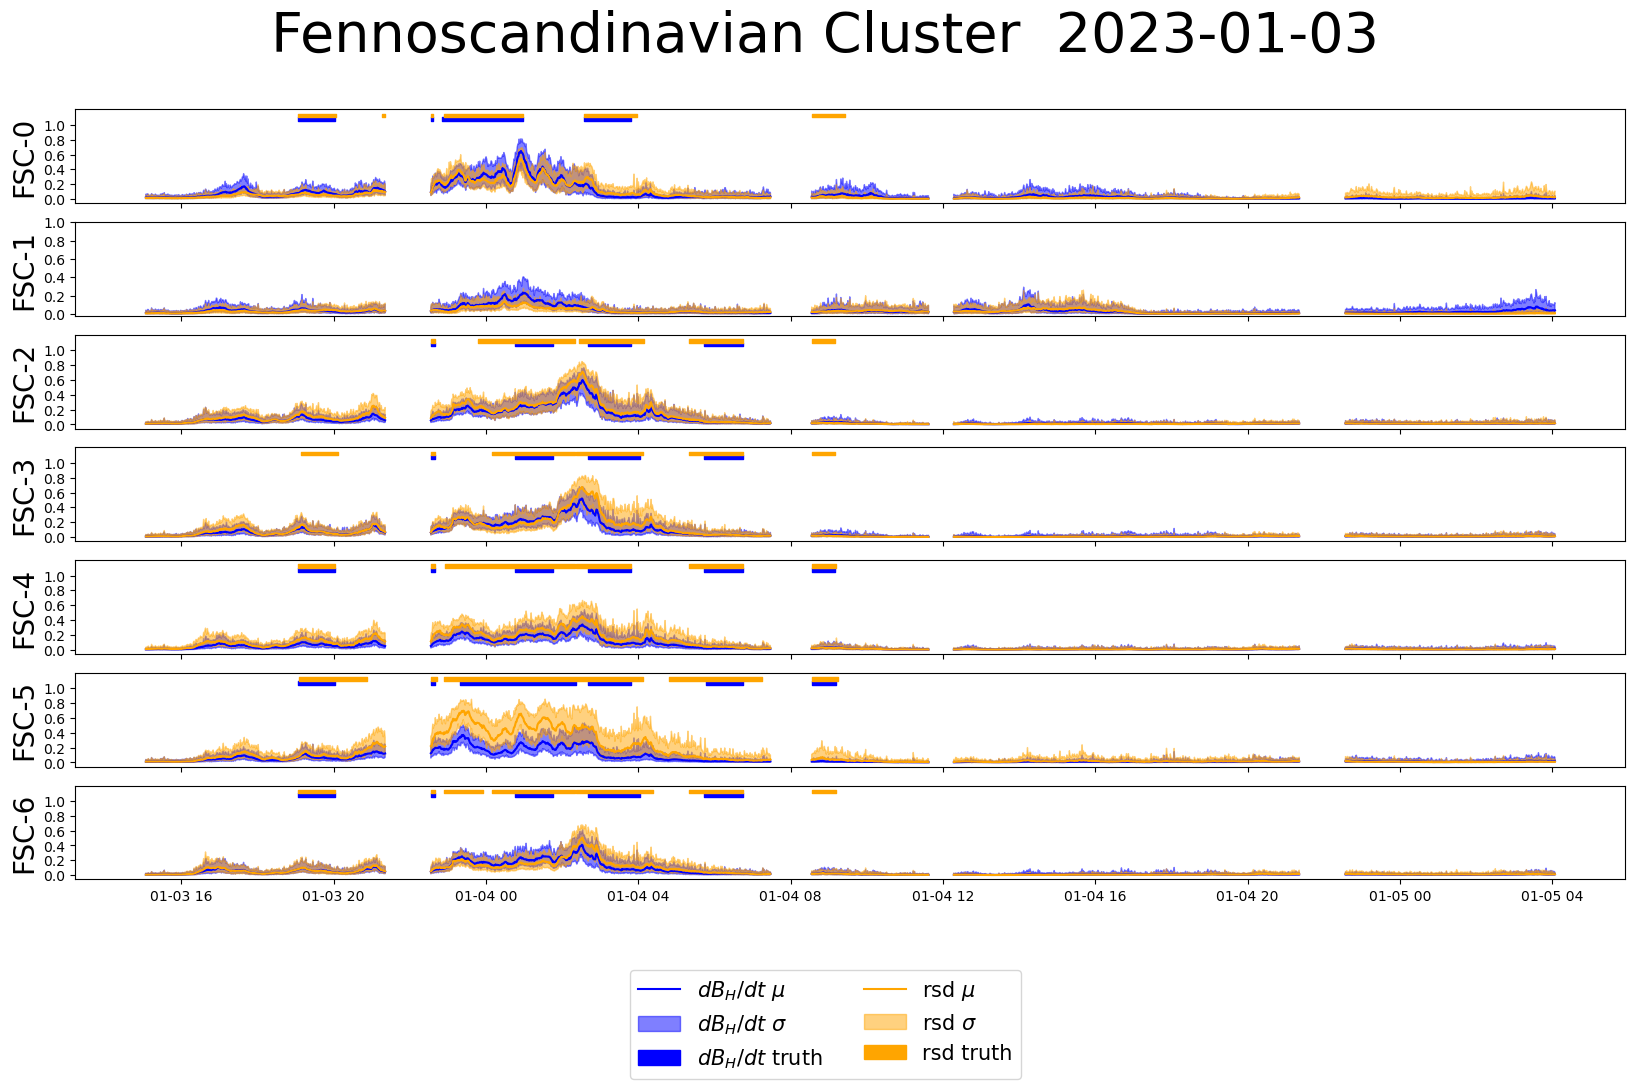

In [10]:
def regularizing_mc_models(df, true_value_elevation, drop_dates=True, drop_actual=True):
	
	plotting_df = pd.DataFrame()
	temp_df = df.copy()
	if 'dates' in temp_df.columns:
		temp_df.drop(columns=['dates'], inplace=True)
	if 'actual' in temp_df.columns:
		temp_df.drop(columns=['actual'], inplace=True)
	if drop_actual:
		plotting_df['top'], plotting_df['bottom'] = df['actual']*(1+(true_value_elevation+1)*0.05), df['actual']*(1+true_value_elevation*0.05)
	else:
		plotting_df['actual'] = df['actual']
	
	plotting_df['predicted_mean'] = temp_df.mean(axis=1)
	plotting_df['predicted_min'] = temp_df.min(axis=1)
	plotting_df['predicted_max'] = temp_df.max(axis=1)
	plotting_df['5th_percentile'] = temp_df.quantile(0.05, axis=1)
	plotting_df['95th_percentile'] = temp_df.quantile(0.95, axis=1)
	plotting_df['predicted_std'] = temp_df.std(axis=1)

	if isinstance(df.index, pd.DatetimeIndex):
		plotting_df.index = df.index
	elif 'dates' in df.columns:
		plotting_df.index = df['dates']
	else:
		raise ValueError('Fool of a Took! No dates column found')
	# if not drop_dates:
	# 	plotting_df['dates'] = df['dates']

	return plotting_df

def cluster_time_series_results(cluster, min_index, max_index, regions=None, group='target'):
	
	if cluster != 'non_cluster':
		cluster_name = cluster+'_cluster'
	elif cluster == 'non_cluster':
		cluster_name = 'non_cluster_regions'
	else:
		raise ValueError('Fool of a Took! Cluster must be either cluster or non_cluster')
	if regions is None:
		regions = [key for key in cluster_dict[cluster_name]['regions'].keys()]
		temp_regions = regions.copy()
	results = {'dbht':{key:{} for key in regions}, 'rsd':{key:{} for key in regions}}
	for region in temp_regions:
		try:
			dbht_df = pd.read_feather(f'{data_dir}mike_working_dir/including_ion_temp_maps/outputs/dbht_max/ml_challenge_region_{region}_extended_v0-1_dbht.feather')
			rsd_df = pd.read_feather(f'{data_dir}mike_working_dir/including_ion_temp_maps/outputs/rsd/ml_challenge_region_{region}_extended_v0-1.feather')
			print(f'{region} sum of actual rsd: {rsd_df["actual"].sum()}')
			
			if isinstance(min_index, int):
				dbht_df.reset_index(inplace=True, drop=True)
				rsd_df.reset_index(inplace=True, drop=True)
				dbht_df.drop('dates', axis=1, inplace=True)
				rsd_df.drop('dates', axis=1, inplace=True)
				results['dbht'][region] = dbht_df.loc[min_index:max_index]
				results['rsd'][region] = rsd_df.loc[min_index:max_index]
			else:
				dbht_df.set_index('dates', inplace=True, drop=True)
				rsd_df.set_index('dates', inplace=True, drop=True)
				dbht_df.index = pd.to_datetime(dbht_df.index, format='%Y-%m-%d %H:%M:%S')
				rsd_df.index = pd.to_datetime(rsd_df.index, format='%Y-%m-%d %H:%M:%S')
				if min_index == max_index:
					min_index = pd.to_datetime(min_index, format='%Y-%m-%d %H:%M:%S') - pd.Timedelta(minutes=1140)
					max_index = pd.to_datetime(max_index, format='%Y-%m-%d %H:%M:%S') + pd.Timedelta(minutes=1140)
				date_index_df = pd.DataFrame(index=pd.date_range(start=min_index, end=max_index, freq='min'))
				dbht_df = dbht_df.sort_index(ascending=True)
				rsd_df = rsd_df.sort_index(ascending=True)
				results['dbht'][region] = date_index_df.join(dbht_df, how='left')
				results['rsd'][region] = date_index_df.join(rsd_df, how='left')
		except:
			print(f'{region} not finished')
			regions.remove(region)
			results['dbht'].pop(region)
			results['rsd'].pop(region)
	if group == 'target':
		colors = sns.color_palette('Set1', len(regions)+1)
		if len(colors) > 5:
			colors = sns.color_palette('Set1', len(regions)+1)
		upper_bound = [1+(i*0.01) for i in range(len(regions))]
		fig, axes = plt.subplots(2,1, figsize=(20, 10), sharex=True)
		# capitalizing the first letter of the region and including the year month adn day of the time series
		fig.suptitle(f'{cluster.capitalize()} Cluster  {min_index.strftime("%Y-%m-%d")}', fontsize=40)
		for i, region in enumerate(regions):
			# results['dbht'][region]['top'] = results['dbht'][region]['actual']*(1+((i+1)*0.03))
			# results['rsd'][region]['top'] = results['rsd'][region]['actual']*(1+((i+1)*0.03))
			# results['dbht'][region]['bottom'] = results['dbht'][region]['actual']*(1+(i*0.03))
			# results['rsd'][region]['bottom'] = results['rsd'][region]['actual']*(1+(i*0.03))
			dbht_plotting_df = regularizing_mc_models(results['dbht'][region], i)
			rsd_plotting_df = regularizing_mc_models(results['rsd'][region], i)
			axes[0].plot(dbht_plotting_df['predicted_mean'], color=colors[i], label=r'$\mu$'+f' {region}')
			axes[0].fill_between(dbht_plotting_df.index, dbht_plotting_df['predicted_min'], dbht_plotting_df['predicted_max'], color=colors[i], alpha=0.5, label=r'$\sigma$' + f' {region}')
			axes[0].fill_between(dbht_plotting_df.index, dbht_plotting_df['top'], dbht_plotting_df['bottom'], color=colors[i], alpha=1, where=dbht_plotting_df['top'] > dbht_plotting_df['bottom'], label='ground truth')
			axes[0].set_ylabel(r'$dB_H/dt$', fontsize=20)
			# limiting the y tick labels to only display up to 1
			axes[0].set_yticks(np.arange(0, 1.1, 0.2))

			axes[1].plot(rsd_plotting_df['predicted_mean'], color=colors[i], label=r'$\mu$'+f' {region}')
			axes[1].fill_between(rsd_plotting_df.index, rsd_plotting_df['predicted_min'], rsd_plotting_df['predicted_max'], color=colors[i], alpha=0.5, label=r'$\sigma$'+f' {region}')
			axes[1].fill_between(rsd_plotting_df.index, rsd_plotting_df['top'], rsd_plotting_df['bottom'], color=colors[i], alpha=1, where=rsd_plotting_df['top'] > rsd_plotting_df['bottom'], label='ground truth')
			axes[1].set_ylabel('RSD', fontsize=20)
			axes[1].set_yticks(np.arange(0, 1.1, 0.2))

		
		handles, labels = axes[0].get_legend_handles_labels()
		fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(regions), fontsize=15)

		# plt.tight_layout()
		plt.savefig(f'plots/{cluster}_cluster_{min_index.strftime("%Y-%m-%d")}_target_split.png')

	elif group == 'region':
		colors = sns.color_palette('Set1', 2)
		upper_bound = [1+(i*0.01) for i in range(2)]
		fig, axes = plt.subplots(len(regions),1, figsize=(20, 10), sharex=True)
		fig.suptitle(f'{cluster.capitalize()} Cluster  {min_index.strftime("%Y-%m-%d")}', fontsize=40)
		for i, region in enumerate(regions):
			# results['dbht'][region]['top'] = results['dbht'][region]['actual']*(1+((1)*0.03))
			# results['rsd'][region]['top'] = results['rsd'][region]['actual']*(1+((2)*0.03))
			# results['dbht'][region]['bottom'] = results['dbht'][region]['actual']*(1+(0*0.03))
			# results['rsd'][region]['bottom'] = results['rsd'][region]['actual']*(1+(1*0.03))

			dbht_plotting_df = regularizing_mc_models(results['dbht'][region], 1)
			rsd_plotting_df = regularizing_mc_models(results['rsd'][region], 2)

			axes[i].plot(dbht_plotting_df['predicted_mean'], color='blue', label=r'$dB_H/dt$ $\mu$')
			axes[i].fill_between(dbht_plotting_df.index, dbht_plotting_df['predicted_min'], dbht_plotting_df['predicted_max'], color='blue', alpha=0.5, label=r'$dB_H/dt$ $\sigma$')
			axes[i].fill_between(dbht_plotting_df.index, dbht_plotting_df['top'], dbht_plotting_df['bottom'], color='blue', alpha=1, where=dbht_plotting_df['top'] > dbht_plotting_df['bottom'], label=r'$dB_H/dt$ truth')
			
			axes[i].plot(rsd_plotting_df['predicted_mean'], color='orange', label=r'rsd $\mu$')
			axes[i].fill_between(rsd_plotting_df.index, rsd_plotting_df['predicted_min'], rsd_plotting_df['predicted_max'], color='orange', alpha=0.5, label=r'rsd $\sigma$')
			axes[i].fill_between(rsd_plotting_df.index, rsd_plotting_df['top'], rsd_plotting_df['bottom'], color='orange', alpha=1, where=rsd_plotting_df['top'] > rsd_plotting_df['bottom'], label='rsd truth')
			axes[i].set_ylabel(region, fontsize=20)
			axes[i].set_yticks(np.arange(0, 1.1, 0.2))		
		handles, labels = axes[0].get_legend_handles_labels()
		fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=15)

		# plt.tight_layout() 
		plt.savefig(f'plots/{cluster}_cluster_{min_index.strftime("%Y-%m-%d")}_region_split.png')

	else:
		raise ValueError('Fool of a Took! Group must be either target or region')	

cluster_time_series_results('fennoscandinavian', '2023-01-04 09:04:00', '2023-01-04 09:04:00', group='region')

In [4]:
file

NameError: name 'file' is not defined